In [ ]:
import pandas as pd
import os
from google.colab import drive, files
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.keras import TqdmCallback
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


# Checking if a GPU is available and set the device accordingly
device = tf.device('/device:GPU:0' if tf.test.is_gpu_available() else '/device:CPU:0')

device

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Colab Notebooks/intern/'

Mounted at /content/drive


In [ ]:
# Function to create EMA
def apply_ema(data, span=10):
    data['t1_ema'] = data['t1'].ewm(span=span, adjust=False).mean()
    data['t2_ema'] = data['t2'].ewm(span=span, adjust=False).mean()
    return data

# Function to create lagged features
def create_lagged_features(data, n_lags=5):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data = pd.concat([lagged_data, data[['t1', 't2']].shift(lag).add_suffix(f'_lag{lag}')], axis=1)
    lagged_data = lagged_data.dropna()  # Drop rows with missing values after lagging
    return lagged_data

# Function to load and preprocess the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)
    df_ema = apply_ema(pd.DataFrame(scaled_data, columns=df.columns))

    lagged_df = create_lagged_features(df_ema, n_lags=5)

    X = lagged_df.dropna().drop(columns=['t1', 't2'])  
    y = lagged_df[['t1', 't2']]  

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

# Initializing model building with GRU
def build_model(X_train):
    model = Sequential([
        GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.5),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(2)  
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
file_directory = '/content/drive/My Drive/Colab Notebooks/intern/'
files = [f for f in os.listdir(file_directory) if f.endswith('.csv')]

predictions = []
true_values = []

initial_file_path = os.path.join(file_directory, files[0])
X_train, X_test, y_train, y_test = preprocess_data(initial_file_path)

initial_model = build_model(X_train)
initial_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                  verbose=0,  # Set verbose to 0 to disable default progress bar
    callbacks=[TqdmCallback(verbose=1)] ) # Add tqdm callback)

initial_model.save('pretrained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
pretrained_model_path = 'pretrained_model.h5'
fine_tuned_model = load_model(pretrained_model_path)
fine_tuned_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
batch_size = 20
predictions = []
true_values = []

for i in range(0, len(files), batch_size):
    batch_files = files[i:i + batch_size]
    print(f"Fine-tuning on batch {i // batch_size + 1}")

    for file in tqdm(batch_files, desc=f"Processing batch {i // batch_size + 1}"):
        file_path = os.path.join(file_directory, file)
        X_train, X_test, y_train, y_test = preprocess_data(file_path)

        fine_tuned_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        y_pred = fine_tuned_model.predict(X_test)
        predictions.append(y_pred)
        true_values.append(y_test)

        # Optionally, plot training history for each file (if needed)

Fine-tuning on batch 1


Processing batch 1:   0%|          | 0/20 [00:00<?, ?it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


Processing batch 1:   5%|▌         | 1/20 [00:54<17:07, 54.07s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  10%|█         | 2/20 [01:36<14:11, 47.32s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  15%|█▌        | 3/20 [02:22<13:12, 46.64s/it]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  20%|██        | 4/20 [02:33<08:42, 32.68s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 1:  25%|██▌       | 5/20 [03:29<10:13, 40.90s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  30%|███       | 6/20 [04:23<10:36, 45.49s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  35%|███▌      | 7/20 [05:15<10:19, 47.69s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 1:  40%|████      | 8/20 [06:16<10:20, 51.69s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  45%|████▌     | 9/20 [07:22<10:18, 56.27s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 1:  50%|█████     | 10/20 [08:30<09:57, 59.77s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  55%|█████▌    | 11/20 [09:35<09:14, 61.57s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  60%|██████    | 12/20 [10:37<08:13, 61.67s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  65%|██████▌   | 13/20 [11:34<07:01, 60.18s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing batch 1:  70%|███████   | 14/20 [12:29<05:51, 58.54s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  75%|███████▌  | 15/20 [13:38<05:09, 61.82s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 1:  80%|████████  | 16/20 [14:33<03:58, 59.73s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  85%|████████▌ | 17/20 [15:33<02:59, 59.80s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  90%|█████████ | 18/20 [16:34<02:00, 60.28s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  95%|█████████▌| 19/20 [17:34<01:00, 60.17s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing batch 1: 100%|██████████| 20/20 [18:31<00:00, 55.58s/it]


Fine-tuning on batch 2


Processing batch 2:   0%|          | 0/20 [00:00<?, ?it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing batch 2:   5%|▌         | 1/20 [00:55<17:34, 55.49s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 2:  10%|█         | 2/20 [02:12<20:27, 68.20s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  15%|█▌        | 3/20 [03:07<17:38, 62.26s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  20%|██        | 4/20 [04:19<17:35, 65.99s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 2:  25%|██▌       | 5/20 [05:25<16:29, 65.97s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  30%|███       | 6/20 [06:36<15:47, 67.68s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  35%|███▌      | 7/20 [07:32<13:50, 63.90s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  40%|████      | 8/20 [08:32<12:33, 62.76s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  45%|████▌     | 9/20 [09:25<10:55, 59.61s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  50%|█████     | 10/20 [10:17<09:30, 57.09s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  55%|█████▌    | 11/20 [11:13<08:32, 56.99s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 2:  60%|██████    | 12/20 [12:11<07:37, 57.21s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  65%|██████▌   | 13/20 [13:13<06:51, 58.75s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  70%|███████   | 14/20 [14:14<05:56, 59.42s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  75%|███████▌  | 15/20 [15:27<05:17, 63.53s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  80%|████████  | 16/20 [16:30<04:12, 63.24s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing batch 2:  85%|████████▌ | 17/20 [17:23<03:00, 60.12s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Processing batch 2:  90%|█████████ | 18/20 [18:19<01:58, 59.09s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2:  95%|█████████▌| 19/20 [19:16<00:58, 58.22s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2: 100%|██████████| 20/20 [20:18<00:00, 60.90s/it]


Fine-tuning on batch 3


Processing batch 3:   0%|          | 0/5 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  20%|██        | 1/5 [00:44<02:56, 44.04s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  40%|████      | 2/5 [01:44<02:40, 53.57s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 3:  60%|██████    | 3/5 [02:42<01:51, 55.85s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  80%|████████  | 4/5 [03:43<00:57, 57.92s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3: 100%|██████████| 5/5 [04:35<00:00, 55.11s/it]


In [ ]:
fine_tuned_model.save('GRU_model.h5')

In [ ]:
from sklearn.metrics import r2_score

test_loss, test_mae = fine_tuned_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Calculate R-squared
y_pred = fine_tuned_model.predict(X_test)  
r2_t1 = r2_score(y_test[:, 0], y_pred[:, 0])  # R² for t1
r2_t2 = r2_score(y_test[:, 1], y_pred[:, 1])  # R² for t2

print(f"R-squared for t1: {r2_t1}")
print(f"R-squared for t2: {r2_t2}")

140/140 - 0s - 2ms/step - loss: 0.0028 - mae: 0.0381
Test Loss: 0.0027957467827945948, Test MAE: 0.038141679018735886
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared for t1: 0.7587265776643164
R-squared for t2: 0.7592092241904388


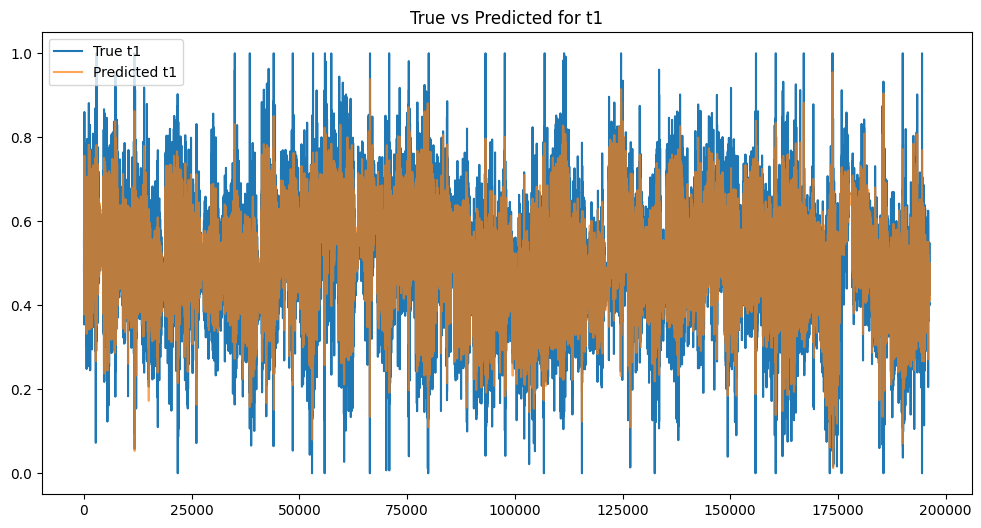

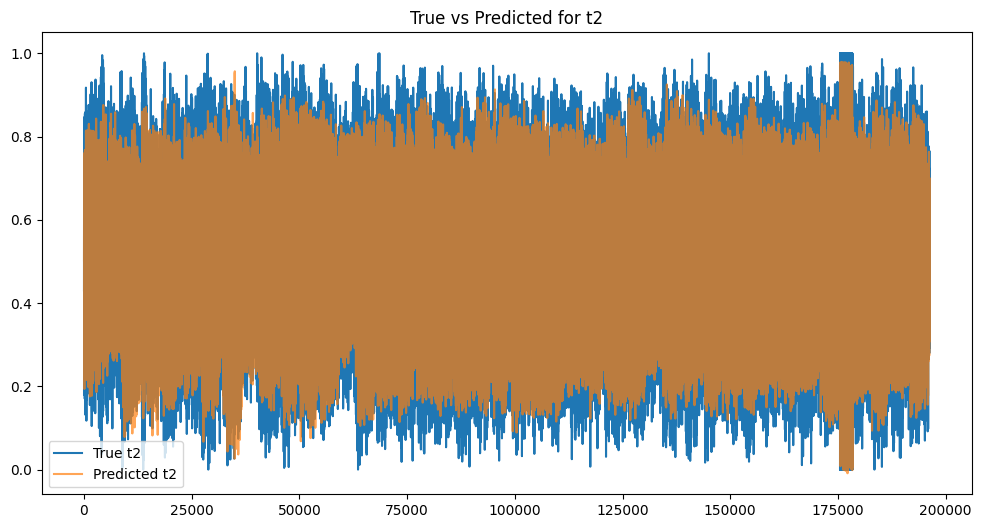

In [ ]:
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Plotting true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(true_values[:, 0], label='True t1')
plt.plot(predictions[:, 0], label='Predicted t1', alpha=0.7)
plt.title('True vs Predicted for t1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(true_values[:, 1], label='True t2')
plt.plot(predictions[:, 1], label='Predicted t2', alpha=0.7)
plt.title('True vs Predicted for t2')
plt.legend()
plt.show()


In [ ]:
# Function to load and preprocess the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)

    df_ema = apply_ema(df)

    lagged_df = create_lagged_features(df_ema, n_lags=5)

    X = lagged_df.dropna().drop(columns=['t1', 't2'])  
    y = lagged_df[['t1', 't2']]  

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    return X, y

# Function to create EMA
def apply_ema(data, span=10):
    data['t1_ema'] = data['t1'].ewm(span=span, adjust=False).mean()
    data['t2_ema'] = data['t2'].ewm(span=span, adjust=False).mean()
    return data

# Function to create lagged features
def create_lagged_features(data, n_lags=5):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data = pd.concat([lagged_data, data[['t1', 't2']].shift(lag).add_suffix(f'_lag{lag}')], axis=1)
    lagged_data = lagged_data.dropna()  
    return lagged_data


# Load the data and preprocess
file_path = '/content/intern_v1_0703.csv'  
X, y = preprocess_data(file_path)


In [ ]:
# Function to forecast for different window sizes 
def forecast(model, X, windows=[60], batch_size=32):
    forecasts = {}
    for N in windows:
        forecasted_values = []

        for i in tqdm(range(0, len(X), batch_size), desc=f"Predicting for window size {N}"):
            batch_input = X[i:i+batch_size, :, :]
            batch_predictions = model.predict(batch_input)
            forecasted_values.append(batch_predictions)

        forecasted_values = np.vstack(forecasted_values)
        forecasts[N] = forecasted_values

    return forecasts

forecasted_values = forecast(load_model("/content/GRU_model.h5"), X)


Predicting for window size 60:   0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Predicting for window size 60:   0%|          | 1/700 [00:00<08:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   0%|          | 3/700 [00:00<02:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   1%|          | 5/700 [00:01<02:30,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   1%|          | 7/700 [00:01<01:44,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   1%|▏         | 9/700 [00:01<01:23,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   2%|▏         | 11/700 [00:01<01:12,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   2%|▏         | 13/700 [00:01<01:03, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:   2%|▏         | 15/700 [00:01<00:59, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:   2%|▏         | 17/700 [00:02<00:57, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:   3%|▎         | 19/700 [00:02<00:56, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   3%|▎         | 21/700 [00:02<00:53, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   3%|▎         | 23/700 [00:02<00:51, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   4%|▎         | 25/700 [00:02<00:49, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   4%|▍         | 27/700 [00:02<00:49, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   4%|▍         | 29/700 [00:02<00:48, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:   4%|▍         | 31/700 [00:03<00:49, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   5%|▍         | 33/700 [00:03<00:51, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   5%|▌         | 35/700 [00:03<00:50, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   5%|▌         | 37/700 [00:03<00:47, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   6%|▌         | 39/700 [00:03<00:48, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   6%|▌         | 41/700 [00:03<00:48, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   6%|▌         | 43/700 [00:04<00:48, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:   6%|▋         | 45/700 [00:04<00:48, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   7%|▋         | 47/700 [00:04<00:51, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   7%|▋         | 49/700 [00:04<00:50, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   7%|▋         | 51/700 [00:04<00:48, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   8%|▊         | 53/700 [00:04<00:47, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   8%|▊         | 55/700 [00:04<00:45, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   8%|▊         | 57/700 [00:05<00:45, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:   8%|▊         | 59/700 [00:05<00:46, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   9%|▊         | 61/700 [00:05<00:47, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:   9%|▉         | 63/700 [00:05<00:48, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   9%|▉         | 65/700 [00:05<00:47, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  10%|▉         | 67/700 [00:05<00:49, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  10%|▉         | 69/700 [00:05<00:48, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  10%|█         | 71/700 [00:06<00:49, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  10%|█         | 73/700 [00:06<00:50, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  11%|█         | 75/700 [00:06<00:48, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  11%|█         | 77/700 [00:06<00:46, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  11%|█▏        | 79/700 [00:06<00:46, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  12%|█▏        | 81/700 [00:06<00:45, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  12%|█▏        | 83/700 [00:07<00:45, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  12%|█▏        | 85/700 [00:07<00:47, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  12%|█▏        | 87/700 [00:07<00:46, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  13%|█▎        | 89/700 [00:07<00:45, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  13%|█▎        | 91/700 [00:07<00:45, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  13%|█▎        | 93/700 [00:07<00:43, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  14%|█▎        | 95/700 [00:07<00:43, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  14%|█▍        | 97/700 [00:08<00:42, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  14%|█▍        | 99/700 [00:08<00:45, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  14%|█▍        | 101/700 [00:08<00:45, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  15%|█▍        | 103/700 [00:08<00:44, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  15%|█▌        | 105/700 [00:08<00:44, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  15%|█▌        | 107/700 [00:08<00:46, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  16%|█▌        | 109/700 [00:09<00:51, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  16%|█▌        | 111/700 [00:09<00:54, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  16%|█▌        | 113/700 [00:09<00:53, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  16%|█▋        | 115/700 [00:09<00:53, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  17%|█▋        | 117/700 [00:09<00:55, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  17%|█▋        | 119/700 [00:10<00:55, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  17%|█▋        | 121/700 [00:10<00:59,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  17%|█▋        | 122/700 [00:10<00:59,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  18%|█▊        | 123/700 [00:10<00:59,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  18%|█▊        | 125/700 [00:10<00:58,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  18%|█▊        | 126/700 [00:10<00:58,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  18%|█▊        | 128/700 [00:10<00:56, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  19%|█▊        | 130/700 [00:11<00:57,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  19%|█▊        | 131/700 [00:11<00:58,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  19%|█▉        | 132/700 [00:11<00:58,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  19%|█▉        | 133/700 [00:11<00:58,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  19%|█▉        | 134/700 [00:11<00:57,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  19%|█▉        | 136/700 [00:11<00:55, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  20%|█▉        | 137/700 [00:11<00:57,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Predicting for window size 60:  20%|█▉        | 138/700 [00:11<00:57,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  20%|█▉        | 139/700 [00:12<00:58,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  20%|██        | 140/700 [00:12<00:59,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  20%|██        | 141/700 [00:12<00:59,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  20%|██        | 143/700 [00:12<00:53, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  21%|██        | 145/700 [00:12<00:48, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  21%|██        | 147/700 [00:12<00:45, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  21%|██▏       | 149/700 [00:12<00:49, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  22%|██▏       | 151/700 [00:13<00:59,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  22%|██▏       | 152/700 [00:13<00:59,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  22%|██▏       | 154/700 [00:13<00:53, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  22%|██▏       | 156/700 [00:13<00:48, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  23%|██▎       | 158/700 [00:13<00:43, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  23%|██▎       | 160/700 [00:13<00:41, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  23%|██▎       | 162/700 [00:14<00:42, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  23%|██▎       | 164/700 [00:14<00:44, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  24%|██▎       | 166/700 [00:14<00:43, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  24%|██▍       | 168/700 [00:14<00:41, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  24%|██▍       | 170/700 [00:14<00:40, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  25%|██▍       | 172/700 [00:14<00:40, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  25%|██▍       | 174/700 [00:15<00:39, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  25%|██▌       | 176/700 [00:15<00:42, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  25%|██▌       | 178/700 [00:15<00:40, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  26%|██▌       | 180/700 [00:15<00:40, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  26%|██▌       | 182/700 [00:15<00:37, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  26%|██▋       | 184/700 [00:15<00:38, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  27%|██▋       | 186/700 [00:15<00:38, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  27%|██▋       | 188/700 [00:16<00:38, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  27%|██▋       | 190/700 [00:16<00:40, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  27%|██▋       | 192/700 [00:16<00:38, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  28%|██▊       | 194/700 [00:16<00:38, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  28%|██▊       | 196/700 [00:16<00:37, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  28%|██▊       | 198/700 [00:16<00:37, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  29%|██▊       | 200/700 [00:17<00:38, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  29%|██▉       | 202/700 [00:17<00:38, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  29%|██▉       | 204/700 [00:17<00:39, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  29%|██▉       | 206/700 [00:17<00:38, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  30%|██▉       | 208/700 [00:17<00:37, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  30%|███       | 210/700 [00:17<00:37, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  30%|███       | 212/700 [00:17<00:37, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  31%|███       | 214/700 [00:18<00:36, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  31%|███       | 216/700 [00:18<00:37, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  31%|███       | 218/700 [00:18<00:36, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  31%|███▏      | 220/700 [00:18<00:36, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  32%|███▏      | 222/700 [00:18<00:36, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  32%|███▏      | 224/700 [00:18<00:36, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  32%|███▏      | 226/700 [00:19<00:35, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  33%|███▎      | 228/700 [00:19<00:35, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  33%|███▎      | 230/700 [00:19<00:37, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  33%|███▎      | 232/700 [00:19<00:35, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  33%|███▎      | 234/700 [00:19<00:35, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  34%|███▎      | 236/700 [00:19<00:34, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  34%|███▍      | 238/700 [00:19<00:33, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  34%|███▍      | 240/700 [00:20<00:33, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  35%|███▍      | 242/700 [00:20<00:33, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  35%|███▍      | 244/700 [00:20<00:33, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  35%|███▌      | 246/700 [00:20<00:32, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  35%|███▌      | 248/700 [00:20<00:33, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  36%|███▌      | 250/700 [00:20<00:33, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  36%|███▌      | 252/700 [00:20<00:33, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  36%|███▋      | 254/700 [00:21<00:32, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  37%|███▋      | 256/700 [00:21<00:33, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  37%|███▋      | 258/700 [00:21<00:34, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  37%|███▋      | 260/700 [00:21<00:34, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  37%|███▋      | 262/700 [00:21<00:32, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  38%|███▊      | 264/700 [00:21<00:32, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  38%|███▊      | 266/700 [00:22<00:32, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  38%|███▊      | 268/700 [00:22<00:32, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  39%|███▊      | 270/700 [00:22<00:33, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  39%|███▉      | 272/700 [00:22<00:36, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  39%|███▉      | 274/700 [00:22<00:38, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  39%|███▉      | 276/700 [00:22<00:38, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  40%|███▉      | 278/700 [00:23<00:39, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  40%|████      | 280/700 [00:23<00:41, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  40%|████      | 282/700 [00:23<00:41, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  41%|████      | 284/700 [00:23<00:41, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  41%|████      | 286/700 [00:23<00:39, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  41%|████      | 288/700 [00:24<00:40, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  41%|████▏     | 290/700 [00:24<00:40, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  42%|████▏     | 292/700 [00:24<00:41,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  42%|████▏     | 293/700 [00:24<00:42,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  42%|████▏     | 295/700 [00:24<00:40,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  42%|████▏     | 297/700 [00:25<00:41,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Predicting for window size 60:  43%|████▎     | 298/700 [00:25<00:43,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  43%|████▎     | 299/700 [00:25<00:43,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  43%|████▎     | 300/700 [00:25<00:43,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  43%|████▎     | 302/700 [00:25<00:39, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  43%|████▎     | 304/700 [00:25<00:34, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  44%|████▎     | 306/700 [00:25<00:33, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  44%|████▍     | 308/700 [00:26<00:31, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  44%|████▍     | 310/700 [00:26<00:30, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  45%|████▍     | 312/700 [00:26<00:31, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  45%|████▍     | 314/700 [00:26<00:30, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  45%|████▌     | 316/700 [00:26<00:30, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  45%|████▌     | 318/700 [00:26<00:29, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  46%|████▌     | 320/700 [00:26<00:29, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  46%|████▌     | 322/700 [00:27<00:28, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  46%|████▋     | 324/700 [00:27<00:29, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  47%|████▋     | 326/700 [00:27<00:28, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  47%|████▋     | 328/700 [00:27<00:28, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  47%|████▋     | 330/700 [00:27<00:28, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  47%|████▋     | 332/700 [00:27<00:27, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  48%|████▊     | 334/700 [00:28<00:27, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  48%|████▊     | 336/700 [00:28<00:27, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  48%|████▊     | 338/700 [00:28<00:28, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  49%|████▊     | 340/700 [00:28<00:26, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  49%|████▉     | 342/700 [00:28<00:27, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  49%|████▉     | 344/700 [00:28<00:26, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  49%|████▉     | 346/700 [00:28<00:26, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  50%|████▉     | 348/700 [00:29<00:26, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  50%|█████     | 350/700 [00:29<00:27, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  50%|█████     | 352/700 [00:29<00:26, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  51%|█████     | 354/700 [00:29<00:25, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  51%|█████     | 356/700 [00:29<00:26, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  51%|█████     | 358/700 [00:29<00:25, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  51%|█████▏    | 360/700 [00:29<00:25, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  52%|█████▏    | 362/700 [00:30<00:25, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  52%|█████▏    | 364/700 [00:30<00:25, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  52%|█████▏    | 366/700 [00:30<00:25, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  53%|█████▎    | 368/700 [00:30<00:25, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  53%|█████▎    | 370/700 [00:30<00:25, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  53%|█████▎    | 372/700 [00:30<00:25, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  53%|█████▎    | 374/700 [00:31<00:24, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  54%|█████▎    | 376/700 [00:31<00:24, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  54%|█████▍    | 378/700 [00:31<00:25, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  54%|█████▍    | 380/700 [00:31<00:24, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  55%|█████▍    | 382/700 [00:31<00:23, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  55%|█████▍    | 384/700 [00:31<00:23, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  55%|█████▌    | 386/700 [00:31<00:23, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  55%|█████▌    | 388/700 [00:32<00:22, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  56%|█████▌    | 390/700 [00:32<00:24, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  56%|█████▌    | 392/700 [00:32<00:23, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  56%|█████▋    | 394/700 [00:32<00:22, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  57%|█████▋    | 396/700 [00:32<00:22, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  57%|█████▋    | 398/700 [00:32<00:22, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  57%|█████▋    | 400/700 [00:32<00:22, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  57%|█████▋    | 402/700 [00:33<00:22, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  58%|█████▊    | 404/700 [00:33<00:23, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  58%|█████▊    | 406/700 [00:33<00:21, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  58%|█████▊    | 408/700 [00:33<00:21, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  59%|█████▊    | 410/700 [00:33<00:21, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  59%|█████▉    | 412/700 [00:33<00:20, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  59%|█████▉    | 414/700 [00:34<00:20, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  59%|█████▉    | 416/700 [00:34<00:21, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  60%|█████▉    | 418/700 [00:34<00:21, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  60%|██████    | 420/700 [00:34<00:21, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  60%|██████    | 422/700 [00:34<00:21, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  61%|██████    | 424/700 [00:34<00:20, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  61%|██████    | 426/700 [00:34<00:20, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  61%|██████    | 428/700 [00:35<00:20, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  61%|██████▏   | 430/700 [00:35<00:21, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  62%|██████▏   | 432/700 [00:35<00:23, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  62%|██████▏   | 434/700 [00:35<00:25, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  62%|██████▏   | 436/700 [00:35<00:25, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting for window size 60:  63%|██████▎   | 438/700 [00:36<00:26,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  63%|██████▎   | 440/700 [00:36<00:25, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  63%|██████▎   | 442/700 [00:36<00:25, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  63%|██████▎   | 444/700 [00:36<00:24, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  64%|██████▎   | 446/700 [00:36<00:24, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  64%|██████▍   | 448/700 [00:37<00:24, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  64%|██████▍   | 450/700 [00:37<00:25,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  64%|██████▍   | 451/700 [00:37<00:25,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  65%|██████▍   | 452/700 [00:37<00:25,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  65%|██████▍   | 453/700 [00:37<00:26,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  65%|██████▍   | 454/700 [00:37<00:26,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  65%|██████▌   | 455/700 [00:37<00:27,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  65%|██████▌   | 456/700 [00:38<00:26,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  65%|██████▌   | 458/700 [00:38<00:26,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  66%|██████▌   | 459/700 [00:38<00:26,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  66%|██████▌   | 460/700 [00:38<00:25,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  66%|██████▌   | 461/700 [00:38<00:25,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  66%|██████▌   | 462/700 [00:38<00:25,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  66%|██████▌   | 463/700 [00:38<00:25,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for window size 60:  66%|██████▋   | 465/700 [00:39<00:26,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  67%|██████▋   | 466/700 [00:39<00:27,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  67%|██████▋   | 467/700 [00:39<00:27,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  67%|██████▋   | 469/700 [00:39<00:23,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  67%|██████▋   | 471/700 [00:39<00:20, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  68%|██████▊   | 473/700 [00:39<00:18, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  68%|██████▊   | 475/700 [00:39<00:18, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  68%|██████▊   | 477/700 [00:40<00:17, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  68%|██████▊   | 479/700 [00:40<00:18, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  69%|██████▊   | 481/700 [00:40<00:18, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  69%|██████▉   | 483/700 [00:40<00:17, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Predicting for window size 60:  69%|██████▉   | 485/700 [00:40<00:20, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  70%|██████▉   | 487/700 [00:41<00:28,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  70%|██████▉   | 489/700 [00:41<00:24,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  70%|███████   | 491/700 [00:41<00:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Predicting for window size 60:  70%|███████   | 493/700 [00:41<00:23,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  71%|███████   | 495/700 [00:42<00:30,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  71%|███████   | 497/700 [00:42<00:25,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  71%|███████▏  | 499/700 [00:42<00:22,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  72%|███████▏  | 501/700 [00:42<00:19, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  72%|███████▏  | 503/700 [00:42<00:18, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  72%|███████▏  | 505/700 [00:42<00:17, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  72%|███████▏  | 507/700 [00:43<00:16, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  73%|███████▎  | 509/700 [00:43<00:16, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  73%|███████▎  | 511/700 [00:43<00:15, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  73%|███████▎  | 513/700 [00:43<00:14, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  74%|███████▎  | 515/700 [00:43<00:14, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  74%|███████▍  | 517/700 [00:43<00:13, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  74%|███████▍  | 519/700 [00:44<00:13, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  74%|███████▍  | 521/700 [00:44<00:14, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  75%|███████▍  | 523/700 [00:44<00:14, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  75%|███████▌  | 525/700 [00:44<00:13, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  75%|███████▌  | 527/700 [00:44<00:13, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  76%|███████▌  | 529/700 [00:44<00:13, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  76%|███████▌  | 531/700 [00:45<00:12, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  76%|███████▌  | 533/700 [00:45<00:12, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  76%|███████▋  | 535/700 [00:45<00:13, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  77%|███████▋  | 537/700 [00:45<00:12, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  77%|███████▋  | 539/700 [00:45<00:12, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  77%|███████▋  | 541/700 [00:45<00:12, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  78%|███████▊  | 543/700 [00:45<00:11, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  78%|███████▊  | 545/700 [00:46<00:11, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  78%|███████▊  | 547/700 [00:46<00:12, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  78%|███████▊  | 549/700 [00:46<00:12, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  79%|███████▊  | 551/700 [00:46<00:11, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  79%|███████▉  | 553/700 [00:46<00:11, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  79%|███████▉  | 555/700 [00:46<00:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  80%|███████▉  | 557/700 [00:46<00:10, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  80%|███████▉  | 559/700 [00:47<00:10, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  80%|████████  | 561/700 [00:47<00:11, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  80%|████████  | 563/700 [00:47<00:10, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  81%|████████  | 565/700 [00:47<00:10, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  81%|████████  | 567/700 [00:47<00:10, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  81%|████████▏ | 569/700 [00:47<00:09, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  82%|████████▏ | 571/700 [00:48<00:09, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  82%|████████▏ | 573/700 [00:48<00:10, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  82%|████████▏ | 575/700 [00:48<00:09, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  82%|████████▏ | 577/700 [00:48<00:09, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  83%|████████▎ | 579/700 [00:48<00:09, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  83%|████████▎ | 581/700 [00:48<00:09, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  83%|████████▎ | 583/700 [00:49<00:08, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  84%|████████▎ | 585/700 [00:49<00:09, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  84%|████████▍ | 587/700 [00:49<00:09, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  84%|████████▍ | 589/700 [00:49<00:10, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  84%|████████▍ | 591/700 [00:49<00:10, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  85%|████████▍ | 593/700 [00:49<00:10, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  85%|████████▌ | 595/700 [00:50<00:10,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  85%|████████▌ | 597/700 [00:50<00:10,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  85%|████████▌ | 598/700 [00:50<00:10,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  86%|████████▌ | 600/700 [00:50<00:09, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  86%|████████▌ | 602/700 [00:50<00:09, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  86%|████████▋ | 604/700 [00:51<00:09,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  87%|████████▋ | 606/700 [00:51<00:09,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  87%|████████▋ | 607/700 [00:51<00:10,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  87%|████████▋ | 608/700 [00:51<00:10,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  87%|████████▋ | 609/700 [00:51<00:10,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  87%|████████▋ | 610/700 [00:51<00:10,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  87%|████████▋ | 611/700 [00:51<00:09,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  87%|████████▋ | 612/700 [00:52<00:09,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Predicting for window size 60:  88%|████████▊ | 613/700 [00:52<00:10,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Predicting for window size 60:  88%|████████▊ | 614/700 [00:52<00:13,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Predicting for window size 60:  88%|████████▊ | 615/700 [00:52<00:15,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Predicting for window size 60:  88%|████████▊ | 616/700 [00:52<00:15,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Predicting for window size 60:  88%|████████▊ | 617/700 [00:53<00:15,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Predicting for window size 60:  88%|████████▊ | 618/700 [00:53<00:17,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Predicting for window size 60:  88%|████████▊ | 619/700 [00:53<00:16,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  89%|████████▊ | 620/700 [00:53<00:16,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  89%|████████▊ | 621/700 [00:53<00:15,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  89%|████████▉ | 622/700 [00:53<00:12,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting for window size 60:  89%|████████▉ | 623/700 [00:54<00:12,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Predicting for window size 60:  89%|████████▉ | 624/700 [00:54<00:15,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Predicting for window size 60:  89%|████████▉ | 625/700 [00:54<00:18,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for window size 60:  89%|████████▉ | 626/700 [00:55<00:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  90%|████████▉ | 627/700 [00:55<00:16,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  90%|████████▉ | 628/700 [00:55<00:13,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  90%|████████▉ | 629/700 [00:55<00:12,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  90%|█████████ | 630/700 [00:55<00:12,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  90%|█████████ | 631/700 [00:55<00:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Predicting for window size 60:  90%|█████████ | 632/700 [00:55<00:11,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting for window size 60:  90%|█████████ | 633/700 [00:56<00:10,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Predicting for window size 60:  91%|█████████ | 634/700 [00:56<00:11,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Predicting for window size 60:  91%|█████████ | 635/700 [00:56<00:10,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  91%|█████████ | 636/700 [00:56<00:09,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Predicting for window size 60:  91%|█████████ | 637/700 [00:56<00:09,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  91%|█████████ | 638/700 [00:56<00:09,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Predicting for window size 60:  91%|█████████▏| 639/700 [00:57<00:10,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  91%|█████████▏| 640/700 [00:57<00:09,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  92%|█████████▏| 641/700 [00:57<00:11,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  92%|█████████▏| 642/700 [00:57<00:11,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  92%|█████████▏| 644/700 [00:57<00:07,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  92%|█████████▏| 646/700 [00:58<00:06,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  93%|█████████▎| 648/700 [00:58<00:05,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  93%|█████████▎| 650/700 [00:58<00:04, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  93%|█████████▎| 652/700 [00:58<00:04, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  93%|█████████▎| 654/700 [00:58<00:03, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  94%|█████████▎| 656/700 [00:58<00:03, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  94%|█████████▍| 658/700 [00:58<00:03, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  94%|█████████▍| 660/700 [00:59<00:03, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  95%|█████████▍| 662/700 [00:59<00:03, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  95%|█████████▍| 664/700 [00:59<00:02, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  95%|█████████▌| 666/700 [00:59<00:02, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  95%|█████████▌| 668/700 [00:59<00:02, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  96%|█████████▌| 670/700 [00:59<00:02, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  96%|█████████▌| 672/700 [01:00<00:02, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  96%|█████████▋| 674/700 [01:00<00:02, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for window size 60:  97%|█████████▋| 676/700 [01:00<00:01, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  97%|█████████▋| 678/700 [01:00<00:01, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  97%|█████████▋| 680/700 [01:00<00:01, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  97%|█████████▋| 682/700 [01:00<00:01, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  98%|█████████▊| 684/700 [01:00<00:01, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  98%|█████████▊| 686/700 [01:01<00:01, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  98%|█████████▊| 688/700 [01:01<00:00, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  99%|█████████▊| 690/700 [01:01<00:00, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  99%|█████████▉| 692/700 [01:01<00:00, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  99%|█████████▉| 694/700 [01:01<00:00, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  99%|█████████▉| 696/700 [01:01<00:00, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60: 100%|█████████▉| 698/700 [01:02<00:00, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


Predicting for window size 60: 100%|██████████| 700/700 [01:02<00:00, 11.14it/s]


In [ ]:

def plot_forecasts(forecasts, true_values):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(len(true_values)), y=true_values[:, 0], mode='lines', name='Actual t1'))
    fig.add_trace(go.Scatter(x=np.arange(len(true_values)), y=true_values[:, 1], mode='lines', name='Actual t2'))

    for window, forecasted in forecasts.items():
        forecasted_x = np.arange(len(true_values), len(true_values) + len(forecasted))

        fig.add_trace(go.Scatter(x=forecasted_x, y=forecasted[:, 0], mode='lines', name=f'Forecasted t1 (N={window})'))
        fig.add_trace(go.Scatter(x=forecasted_x, y=forecasted[:, 1], mode='lines', name=f'Forecasted t2 (N={window})'))

    fig.update_layout(title='True and Forecasted Values for t1 and t2',
                      xaxis_title='Time Steps',
                      yaxis_title='Values',
                      template='plotly_dark')

    fig.show()

plot_forecasts(forecasted_values, y)
